Prepare the environment

In [1]:
import tensorflow as tf

Extract data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
base_dir = '/content/drive/MyDrive/rockpaperscissors'

Checking extracted directory

In [4]:
os.listdir(base_dir)

['none', 'paper', 'rock', 'scissors']

Data Preprocessing, Auto-labelling, and Image Augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.4) #set validation split to 40% from total data

In [7]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(227, 227), 
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=341, #random seed for shuffling and transformations
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    base_dir, # same directory as training data
    target_size=(227, 227),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=341,
    subset='validation') # set as validation data

Found 480 images belonging to 4 classes.
Found 320 images belonging to 4 classes.


Building Convolutional Neural Network (CNN) model

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(227, 227, 3)), #Since the image is in RGB, there are 3 channels, 'R', 'G', and 'B'.
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2), #To minimize overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [13]:
#Check model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 225, 225, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 128)     

In [14]:
#Compile model with 'adam' optimizer and 'categorical_crossentropy' loss function
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

Create a custom callback that stop the training when accuracy reach 99%

In [15]:
class CallbackThreshold(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(CallbackThreshold, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs={}): 
        accuracy = logs.get('accuracy')
        if accuracy is not None and accuracy >= self.threshold:
          print("\nReached %2.2f%% accuracy, so stopping training." %(self.threshold*100)),
          self.model.stop_training = True

callback = CallbackThreshold(threshold=0.99)

Fit and train the model

In [16]:
history = model.fit(
      train_generator,
      steps_per_epoch=15,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=10,
      callbacks=[callback],
      verbose=1)

Epoch 1/20
15/15 [==============================] - 237s 16s/step - loss: 1.6067 - accuracy: 0.2229 - val_loss: 1.3050 - val_accuracy: 0.4844
Epoch 2/20
15/15 [==============================] - 66s 4s/step - loss: 1.0715 - accuracy: 0.5771 - val_loss: 0.7320 - val_accuracy: 0.8281
Epoch 3/20
15/15 [==============================] - 65s 4s/step - loss: 0.5680 - accuracy: 0.8062 - val_loss: 0.4326 - val_accuracy: 0.9000
Epoch 4/20
15/15 [==============================] - 64s 4s/step - loss: 0.1637 - accuracy: 0.9583 - val_loss: 0.2209 - val_accuracy: 0.9469
Epoch 5/20
15/15 [==============================] - 67s 4s/step - loss: 0.0693 - accuracy: 0.9812 - val_loss: 0.1805 - val_accuracy: 0.9344
Epoch 6/20
15/15 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9937
Reached 99.00% accuracy, so stopping training.
15/15 [==============================] - 68s 5s/step - loss: 0.0295 - accuracy: 0.9937 - val_loss: 0.3578 - val_accuracy: 0.8687


Testing the model

Saving 13.jpg to 13.jpg
1/1 [==============================] - 0s 48ms/step
13.jpg
[[0. 0. 1. 0.]]
Rock


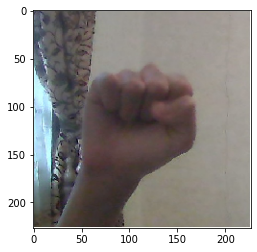

In [22]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
# predicting images
  path = fn
  img = image.load_img(path, target_size=(227,227))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])


  classes = model.predict(images, batch_size=10)  
  print(fn)
  print(classes)
  if classes[0,0] != 0:
   print('None')
  elif classes[0,1] != 0:
   print('Paper')
  elif classes[0,2] != 0:
    print('Rock')
  else:
    print('Scissors')

Saving the model

In [24]:
model.save('rock-paper-scissors-model.h5')